In [22]:
import os 
import dill
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import jax
import jax.numpy as jnp
from getdist import plots, MCSamples
import getdist
import glob
from astropy.io import fits
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median
import scipy.stats as ss 
from scipy.special import logsumexp
import tqdm
import torch 
import random
import torch.nn as nn
import flowtorch.bijectors as bij
import flowtorch.distributions as tdist
import flowtorch.parameters as params
from sklearn.model_selection import train_test_split

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 20

wCDM = True

# Data

In [47]:
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
covariance = np.load("data/covariance.npz")["arr_0"]
ndata = len(data)

In [48]:
print(f"Shape of covariane matrix: {covariance.shape}")

Shape of covariane matrix: (740, 740)


In [49]:
# data -> mb
# the redshift values -> zcmb
# log stellar mass values -> 3rdvar
# x1 values -> x1
# color values -> color

columns = ["mb", "zcmb", "3rdvar", "x1", "color"]
data_filtered = data[columns]
data_filtered.columns = ["mb", "redshift", "M_stellar", "X_1", "C"]

In [50]:
data_filtered.head()

,mb,redshift,M_stellar,X_1,C
0,23.001698,0.503084,9.517,1.273191,-0.012353
1,23.573937,0.580724,9.169,0.974346,-0.025076
2,22.960139,0.494795,11.580,-0.728837,-0.099683
3,22.398137,0.345928,10.821,-1.155110,-0.040581
4,24.078115,0.677662,8.647,0.618820,-0.039380


# Theory
We need some code here to compute the forward model (and we should be able to show an approximate theory and the data before proceeding with the next section). The cosmological and nuisance parameters are:

$$
\theta = (\Omega_{m},\,w_{0},\,M_{B},\,\delta M,\, \alpha,\, \beta)
$$

Therefore, we need a function which takes as input these parameters and outputs the apparent magnitude (the theory).

The luminosity distance is:

$$
D_{L}(z) = \dfrac{10^{5}(1+z)c}{H_{0}}\int_{0}^{z}\dfrac{1}{\sqrt{\Omega_{m}(1+z')^{3}+(1-\Omega_{m})(1+z')^{3(w_{0}+1)}}}\,dz'
$$

where $c=299792.458\,\textrm{km}\,\textrm{s}^{-1}$ is the speed of light and $H_{0}=70.0\,\textrm{km}\,\textrm{s}^{-1}\,\textrm{Mpc}^{-1}$ is the Hubble constant. 

The apparent magnitude in terms of the light-curve stretch, $X_{1}$ and colour at maximum brightness, $C$ is 

$$
m_{B} = 5\,\textrm{log}_{10}\,D_{L}(z) + M_{B} + \delta M\Theta(M_{\textrm{stellar}}-10^{10}M_{\odot}) -\alpha X_{1} + \beta C
$$

where $\Theta$ is the Heaviside function and $M_{B}$ is the absolute magnitude. 



In [51]:
def compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params):
    """
    Compute the apparent magnitude based on cosmological parameters, redshift, and nuisance parameters.

    Parameters:
    -----------
    redshift : float
        The redshift of the object.
    m_stellar : float
        The stellar mass of the object.
    x_1 : float
        The stretch parameter for the supernova.
    color : float
        The color parameter for the supernova.
    cosmo_params : tuple
        A tuple containing the cosmological parameters:
        - omega_matter (float): The matter density parameter.
        - w_0 (float): The equation of state parameter for dark energy.
    nuisance_params : tuple
        A tuple containing the nuisance parameters:
        - m_b (float): The base magnitude.
        - delta_m (float): The change in magnitude for stellar mass > 10.
        - alpha (float): The stretch correction parameter.
        - beta (float): The color correction parameter.

    Returns:
    --------
    float
        The apparent magnitude computed from the cosmological and nuisance parameters.

    Notes:
    ------
    The function computes the apparent magnitude by first calculating the cosmological component,
    which is determined by integrating over a redshift grid using the trapezoidal rule. The nuisance
    component is then added, where the base magnitude may be adjusted by delta_m if the stellar mass
    is greater than 10. The stretch and color corrections are also applied to the nuisance component.
    """
    # unpack the parameters
    omega_matter, w_0 = cosmo_params
    
    m_b, delta_m, alpha, beta = nuisance_params

    # cosmological part
    factor = 10**5 * (1.0 + redshift) * 299792.458 / 70.0
    zgrid = jnp.linspace(0.0, redshift, 1000)

    fgrid = 1.0 / jnp.sqrt(
        omega_matter * (1 + zgrid) ** 3
        + (1 - omega_matter) * (1 + zgrid) ** (3 * (1 + w_0))
    )

    cosmology = 5.0 * jnp.log10(factor * jnp.trapezoid(fgrid, zgrid))

    # nuisance part
    def use_delta_m(m_b):
        return m_b + delta_m

    def skip_delta_m(m_b):
        return m_b

    nuisance = (
        jax.lax.cond(m_stellar > 10, use_delta_m, skip_delta_m, m_b)
        - alpha * x_1
        + beta * color
    )

    return cosmology + nuisance

Here, I am setting three of the nuisance parameters to zero, so we can just visualise the smooth function for the apparent magnitude.

In [52]:
cosmo_params = [0.3, -1.0]
nuisance_params = [-19.0, 0.0, 0.125, 2.62]
inputs = data_filtered[["redshift", "M_stellar", "X_1", "C"]].values

Here, we are computing the theoretical apparent magnitude for a single supernovae at a fixed set of cosmological and nuisance parameters. 

In [53]:
compute_app_mag(*inputs[0], cosmo_params, nuisance_params)

Array(23.085691, dtype=float32)

Here, we are using calculating the theoretical apparent magnitude for all the supernova at a fixed set of cosmological and nuisance parameters.

In [54]:
def compute_theory(inputs):
    """
    Compute the theoretical apparent magnitudes for a set of supernovae using cosmological and nuisance parameters.

    Parameters:
    -----------
    inputs : jax.numpy.ndarray
        An N x 4 array where N is the number of supernovae (in this case, 740). Each row corresponds to a supernova and contains:
        - redshift (float): The redshift of the supernova.
        - m_stellar (float): The stellar mass of the supernova.
        - x_1 (float): The stretch parameter for the supernova.
        - color (float): The color parameter for the supernova.

    Returns:
    --------
    jax.numpy.ndarray
        An array of length N containing the apparent magnitudes computed from the given inputs and pre-defined cosmological and nuisance parameters.

    Notes:
    ------
    This function processes an array of inputs, each representing a supernova, and computes the apparent magnitude for each one
    using the `compute_app_mag` function. The `compute_app_mag` function is called with the individual parameters unpacked from each row
    of the `inputs` array along with the global cosmological and nuisance parameters.
    """
    redshift, m_stellar, x_1, color = inputs
    return compute_app_mag(
        redshift, m_stellar, x_1, color, cosmo_params, nuisance_params
    )

In [55]:
predicted_magnitudes = jax.lax.map(compute_theory, inputs)

Sort the redshift so we can use it to interpolate smoothly between the maximum and maximum.

In [56]:
idx = np.argsort(data_filtered["redshift"].values)
z_sorted = data_filtered["redshift"].values[idx]
mb_sorted = predicted_magnitudes[idx]

Create a fine grid of redshift and interpolate.

In [57]:
z_grid = jnp.linspace(z_sorted[0], z_sorted[-1], 1000)
mb_grid = jnp.interp(z_grid, z_sorted, mb_sorted)

Here, we get the error on the magnitudes (which is simply the square root of the diagonal of the covariance matrix). 

We also compute the correlation matrix (between -1 and 1). 

In [58]:
sigma = jnp.sqrt(jnp.diag(covariance))
correlation = np.zeros_like(covariance)

for i in range(ndata):
    for j in range(ndata):
        correlation[i, j] = covariance[i, j] / np.sqrt(
            covariance[i, i] * covariance[j, j]
        )

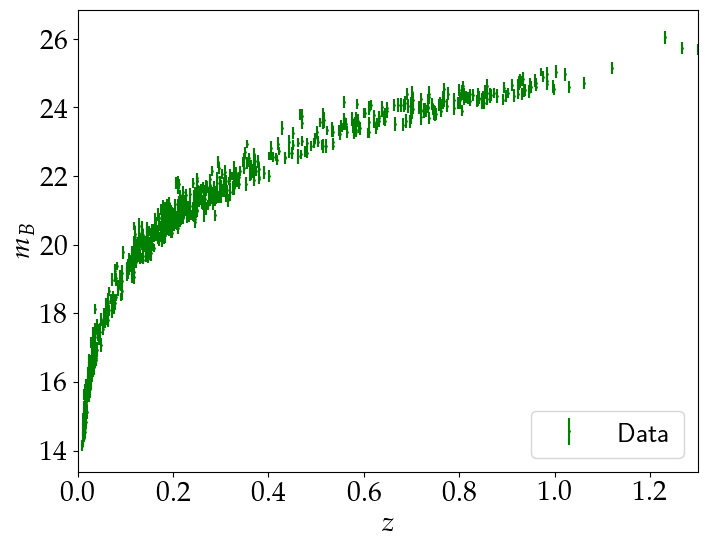

In [109]:
plt.figure(figsize=(8, 6))
plt.errorbar(
    z_sorted,
    data_filtered["mb"].values[idx],
    yerr=sigma,
    fmt="go",
    markersize=1,
    label="Data",
)
# plt.plot(z_grid, mb_grid, c="k", lw=3, label="Theory")
plt.xlim(0.0, max(z_grid))
plt.ylabel(r"$m_{B}$", fontsize=fontSize)
plt.xlabel(r"$z$", fontsize=fontSize)
plt.tick_params(axis="x", labelsize=fontSize)
plt.tick_params(axis="y", labelsize=fontSize)
plt.legend(loc="lower right", prop={"family": "sans-serif", "size": 20})
# plt.savefig('plots/jla_data.pdf', bbox_inches = 'tight')
plt.show()

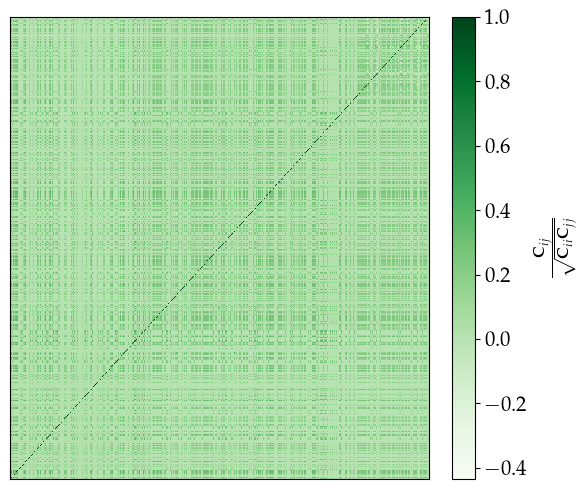

In [110]:
fig, ax = plt.subplots(figsize=(6, 6))
heatmap = ax.pcolor(correlation, cmap=plt.cm.Greens, rasterized=True)
cbar = plt.colorbar(heatmap, fraction=0.05)
cbar.set_label(
    r"$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$", size=15
)
cbar.ax.tick_params(labelsize=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('plots/jla_covariance.pdf', bbox_inches = 'tight')
plt.show()

# Inference
We need some code here to do the inference of the parameters. There is a nice introduction to `numpyro` [here](https://dfm.io/posts/intro-to-numpyro/). We also need priors on the parameters. Let us use the following:

- $\Omega_{m}\sim U[0.001, 0.6]$
- $w_{0}\sim U[-1.5, 0.0]$
- $M_{B}\sim \mathcal{N}(-19.0, 1.0)$  
- $\delta M \sim \mathcal{N}(-0.05, 1.0)$
- $\alpha \sim \mathcal{N}(0.125, 1.0)$
- $\beta \sim \mathcal{N}(2.6, 1.0)$

Some demo of samplers can be found here: https://chi-feng.github.io/mcmc-demo/app.html

In [61]:
precision = jnp.linalg.inv(covariance)

In [62]:
def log_like(data, precision, inputs, cosmo_params, nuisance_params):

    def compute_theory(inputs):
        redshift, m_stellar, x_1, color = inputs
        return compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params)
    theory = jax.lax.map(compute_theory, inputs)

    residual = data - np.asarray(theory)
    chi2 = residual @  precision @ residual
    return -0.5*chi2.item()

In [63]:
log_like(data_filtered['mb'].values, precision, inputs, cosmo_params, nuisance_params)

-384.69647216796875

In [64]:
cosmos = np.ones((100, 2))*-1
cosmos[:,0] = np.linspace(0.001, 1.0, 100)

In [65]:
record = []
for cosmo in cosmos:
    logl = log_like(data_filtered['mb'].values, covariance, inputs, cosmo, nuisance_params)
    record.append(logl)
    # print(f'log-likelihood: {logl:.3f}')
record = np.asarray(record)

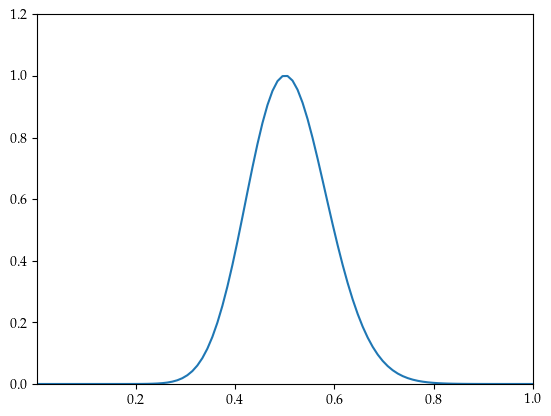

In [66]:
plt.plot(cosmos[:,0], np.exp(record - np.max(record)))
plt.ylim(0.0, 1.2)
plt.xlim(min(cosmos[:,0]), max(cosmos[:,0]))
plt.show()

In [67]:
def numpyro_model(data, covariance, inputs):
    """
    A numpyro model to estimate cosmological parameters using supernova data,
    supporting both Lambda-CDM and wCDM cosmological models.
    
    Args:
        data: The observed data array (e.g., apparent magnitudes).
        covariance: The covariance matrix for the observed data.
        inputs: A tuple containing arrays for redshift, stellar mass, x_1, and color.
        model_type: A string specifying the cosmological model to use ("wCDM" or "LambdaCDM").
    
    Returns:
        None. This function defines the probabilistic model for use with numpyro.
    """
    # Priors for the cosmological parameters
    Omega_m = numpyro.sample('Omega_m', dist.Uniform(0.001, 0.6))

    if wCDM:
        w_0 = numpyro.sample('w_0', dist.Uniform(-1.50, 0.0))
    else:
        w_0 = jnp.ones(1) * -1
    
    # Priors for the nuisance parameters
    abs_mag = numpyro.sample('abs_mag', dist.Normal(-19.0, 1.0))
    delta_m = numpyro.sample('delta_m', dist.Normal(-0.05, 1.0))
    alpha = numpyro.sample('alpha', dist.Normal(0.125, 1.0))
    beta = numpyro.sample('beta', dist.Normal(2.6, 1.0))

    # Pack parameters
    cosmo_params = (Omega_m, w_0)
    nuisance_params = (abs_mag, delta_m, alpha, beta)
    
    def compute_theory(inputs):
        redshift, m_stellar, x_1, color = inputs
        return compute_app_mag(redshift, m_stellar, x_1, color, cosmo_params, nuisance_params)
    theory = jax.lax.map(compute_theory, inputs)
    
    # the sampling distribution
    sampling_distribution = dist.MultivariateNormal(theory, covariance_matrix=covariance)
    numpyro.sample("obs", sampling_distribution, obs=data)

In [68]:
NWARMUP = 500
NSAMPLES = 15000
EPS = 0.1
NCHAIN = 2
TREE_DEPTH = 5 

In [69]:
nuts_kernel = NUTS(numpyro_model, step_size=EPS, init_strategy=init_to_median, dense_mass=True, max_tree_depth=TREE_DEPTH)

In [70]:
mcmc_nuts = MCMC(nuts_kernel, 
                 num_warmup=NWARMUP, 
                 num_samples=NSAMPLES, 
                 num_chains=NCHAIN, 
                 chain_method="vectorized",
                 progress_bar=True)

In [71]:
mcmc_nuts.run(jax.random.PRNGKey(253), 
              extra_fields=("potential_energy",), 
              data=data_filtered['mb'].values, 
              covariance=covariance, 
              inputs=inputs)

sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [2:06:09<00:00,  2.05it/s]


Some functions to save and load the MCMC object.

In [72]:
# omega_matter = mcmc_nuts.get_samples()['Omega_m']
# omega_lambda = 1.0 - mcmc_nuts.get_samples()['Omega_m']

# plt.hist(omega_matter, density=True)
# plt.show()

# plt.hist(omega_lambda, density=True)
# plt.show()

In [3]:
def dill_save(file: Any, folder: str, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        folder (str): folder where we want to store the file
        fname (str): the name of the file.
    """
    os.makedirs(folder, exist_ok=True)
    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)


def dill_load(folder: str, fname: str) -> Any:
    """Reads a file from a folder.
    Args:
        folder(str): the name of the folder.
        file (str): the name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = dill.load(dummy)
    return file

In [74]:
dill_save(mcmc_nuts, 'samples', 'jla-wCDM')

In [100]:
nuts_object = dill_load('samples', 'jla-wCDM')
nuts_object.get_samples()

{'Omega_m': Array([0.21751451, 0.27333766, 0.24319384, ..., 0.3518999 , 0.1747916 ,
        0.38317674], dtype=float32),
 'abs_mag': Array([-19.028318, -19.009441, -19.039253, ..., -19.028004, -19.01089 ,
        -19.036861], dtype=float32),
 'alpha': Array([0.12854   , 0.1215132 , 0.13237192, ..., 0.12973574, 0.12087397,
        0.1314342 ], dtype=float32),
 'beta': Array([2.5942616, 2.7031326, 2.7926059, ..., 2.5772285, 2.6928205,
        2.713005 ], dtype=float32),
 'delta_m': Array([-0.06212714, -0.07510861, -0.04152629, ..., -0.05616871,
        -0.0896244 , -0.04433759], dtype=float32),
 'w_0': Array([-0.73974985, -0.80120945, -0.87694633, ..., -0.96786994,
        -0.71839374, -1.0398037 ], dtype=float32)}

# Posterior Plot and Analysis
We need some code here to plot the results. There is a nice tutorial of how to generate beautiful plots [here](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

In [101]:
from getdist import plots, MCSamples
from matplotlib import cm 
import getdist 

color1 = "#50C878" 
settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}

In [102]:
samples = nuts_object.get_samples()

if wCDM:
    columns = ['Omega_m', 'w_0', 'abs_mag', 'delta_m', 'alpha', 'beta']
    labels = [
        r"$\Omega_{m}$",
        r"$w_{0}$",
        r"$M$",
        r"$\delta M$",
        r"$\alpha$",
        r"$\beta$"]
else:
    columns = ['Omega_m', 'abs_mag', 'delta_m', 'alpha', 'beta']
    labels = [
        r"$\Omega_{m}$",
        r"$M$",
        r"$\delta M$",
        r"$\alpha$",
        r"$\beta$"]
mcmc_samples = np.vstack([samples[c] for c in columns]).T

In [103]:
ndim = len(columns)
names = ["x%s"%i for i in range(ndim)]
getdist_samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, ranges={'x0':(0.0, None)}, label = 'JLA (NUTS)', settings = settings)

Removed no burn in


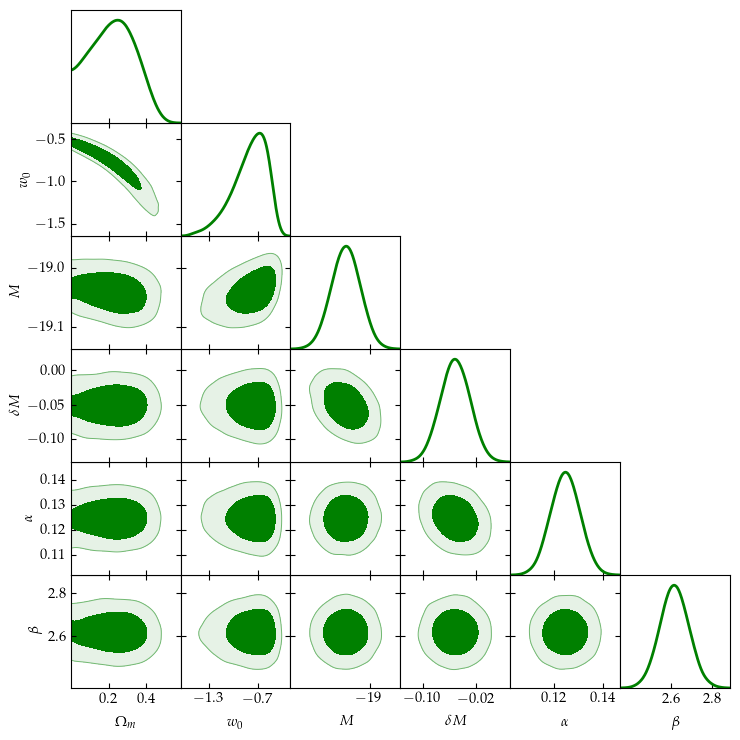

In [104]:
G = plots.getSubplotPlotter(subplot_size=1.25)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  
G.settings.legend_fontsize = 15
getdist_samples.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot([getdist_samples],
    filled=[True],
    contour_colors=['green'],
    contour_lws=[2],
    contour_ls=["-"],
)
# plt.savefig('plots/triangle_plot.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [105]:
nuts_object.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.22      0.11      0.22      0.01      0.38   3627.81      1.00
   abs_mag    -19.04      0.02    -19.04    -19.08    -19.00  15943.11      1.00
     alpha      0.12      0.01      0.12      0.12      0.13  28254.43      1.00
      beta      2.62      0.07      2.62      2.51      2.73  19237.82      1.00
   delta_m     -0.05      0.02     -0.05     -0.09     -0.02  19177.60      1.00
       w_0     -0.81      0.20     -0.77     -1.12     -0.51   4199.15      1.00

Number of divergences: 0


## Evidence Estimate

In [815]:

class ThetaTransform:
    """
    A class to perform a linear transformation on parameter samples using a Cholesky decomposition 
    of their covariance matrix. The transformation standardizes the parameters such that they are 
    transformed to a new space where their covariance is the identity matrix.

    Attributes:
    ----------
    ndim : int
        The number of dimensions of the parameter samples.
    pcov : ndarray
        Covariance matrix of the input samples.
    chol : ndarray
        Cholesky decomposition (lower triangular) of the covariance matrix.
    chol_inv : ndarray
        Inverse of the Cholesky decomposition.
    mean : ndarray
        Mean vector of the input samples.
    logdetchol : float
        Logarithm of the determinant of the Cholesky matrix.

    Methods:
    -------
    forward(parameter):
        Transforms the input parameters to the standardized space using the inverse Cholesky transform.
    
    inverse(parameterprime):
        Transforms parameters from the standardized space back to the original parameter space.
    """

    def __init__(self, samples):
        """
        Initializes the ThetaTransform object with parameter samples.
        
        Parameters:
        ----------
        samples : ndarray
            A 2D array of shape (N, D) where N is the number of samples and D is the dimensionality of the parameters.
        """
        self.ndim = samples.shape[1]
        self.pcov = np.cov(samples.T)
        
        if self.ndim >=2:
            self.chol = np.linalg.cholesky(self.pcov)
            self.chol_inv = np.linalg.inv(self.chol)
            self.logdetchol = np.linalg.slogdet(self.chol)[1]
            
        else:
            self.chol = np.sqrt(self.pcov)
            self.chol_inv = 1.0 / self.chol
            self.logdetchol = np.log(self.chol)
            
        self.mean = np.mean(samples, axis=0).reshape(-1, self.ndim)
        

    def forward(self, parameter):
        """
        Transforms the input parameter(s) to the standardized space using the inverse Cholesky decomposition.
        
        Parameters:
        ----------
        parameter : ndarray
            A 1D or 2D array of shape (D,) or (N, D) where D is the dimensionality of the parameters and N is the number of parameter sets.
        
        Returns:
        -------
        parameterprime : ndarray
            The transformed parameter(s) in the standardized space, with the same shape as the input.
        """
        parameter = parameter.reshape(-1, self.ndim)
        if self.ndim >= 2:
            parameterprime = self.chol_inv @ (parameter - self.mean).T
            return parameterprime.T
        parameterprime = (parameter - self.mean) / self.chol
        return parameterprime
        

    def inverse(self, parameterprime):
        """
        Transforms the parameter(s) from the standardized space back to the original parameter space.
        
        Parameters:
        ----------
        parameterprime : ndarray
            A 1D or 2D array of shape (D,) or (N, D) where D is the dimensionality of the standardized parameters and N is the number of parameter sets.
        
        Returns:
        -------
        parameter : ndarray
            The parameter(s) transformed back to the original space, with the same shape as the input.
        """
        parameterprime = parameterprime.reshape(-1, self.ndim)
        if self.ndim >= 2:
            parameter = self.chol @ parameterprime.T + self.mean.T
            return parameter.T
        parameter = self.chol * parameterprime + self.mean
        return parameter

def logprior(theta):
    """
    Compute the log-prior probability density of the model parameters theta under a multivariate normal prior.

    Parameters:
    ----------
    theta : array-like
        A 1D or 2D array representing the model parameters. If a 1D array is passed, it will be converted to 
        a 2D array where each row is a set of parameters. The shape of `theta` is (n_samples, n_params), where
        n_samples is the number of parameter sets and n_params is the number of parameters in each set.

    Returns:
    -------
    float
        The log-prior value of the parameter set `theta`, assuming a multivariate normal prior distribution 
        with zero mean and identity covariance matrix.

    Notes:
    ------
    - This function assumes a standard multivariate normal prior with a mean of zero and an identity 
      covariance matrix, i.e., `N(0, I)`, where `I` is the identity matrix.
    - The log-prior is often used in Bayesian inference to quantify the prior belief about the model parameters 
      before observing any data. It reflects how likely certain parameter values are based on prior knowledge.

    Example:
    --------
    If you have a parameter vector `theta`, you can compute its log-prior as follows:
    
    >>> logprior(theta)
    
    This will return the log of the prior probability density of `theta` assuming a multivariate normal 
    prior with zero mean and identity covariance.

    """
    theta = np.atleast_2d(theta)
    nparams = theta.shape[1]
    mean = np.zeros(nparams)
    cov = np.eye(nparams)
    dist = ss.multivariate_normal(mean, cov)
    return dist.logpdf(theta)

def build_network(hidden=(32, 32, 32)):
    """Creates a function to do the mapping

    Args:
        hidden (tuple, optional): Number of hidden layers. Defaults to (32, 32, 32).

    Returns:
        flowtorch.lazy.lazy: a composition of bijectors
    """

    transforms = bij.Compose(
        bijectors=[
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
        ]
    )
    return transforms

        
class NormFlow:
    def __init__(self, samples):

        ndim = samples.shape[1]
        mean = torch.zeros(ndim)
        std = torch.ones(ndim)
        self.dataset = torch.tensor(samples, dtype=torch.float)
        dist_x = torch.distributions.Independent(
            torch.distributions.Normal(mean, std), 1
        )
        if ndim >= 2:
            bijector = build_network(hidden=(16, 16, 16))
        else:
            bijector_1 = bij.Spline(count_bins=20, order='linear')
            bijector_2 = bij.Spline(count_bins=5, order='quadratic')
            bijector = bij.Compose(bijectors=[bijector_1, bij.Sigmoid(), bijector_2])
        self.dist_y = tdist.Flow(dist_x, bijector)

    def training(self, lr: float = 5e-3, nsteps: int = 1000) -> list:
        """Train the normalising flow

        Args:
            lr (float, optional): the learning rate. Defaults to 5e-3.
            nsteps (int, optional): the number of steps. Defaults to 1000.

        Returns:
            list: a list of the loss values at each iteration.
        """
        optimizer = torch.optim.Adam(self.dist_y.parameters(), lr=lr)
        record = []
        interval = divmod(nsteps, 20)[0]
        with tqdm.trange(nsteps) as bar:
            for step in bar:
                optimizer.zero_grad()
                loss = -self.dist_y.log_prob(self.dataset).mean() 
                loss.backward()
                optimizer.step()
                record.append(loss.item())
                postfix = dict(Loss=f"{loss.item():.3f}")
                bar.set_postfix(postfix)
        return record


    def logpdf(self, parameter: np.ndarray) -> np.ndarray:
        """Calculates the log-probability of the flow given a sample.

        Args:
            parameter (np.ndarray): a test point in Cosmological parameter space.

        Returns:
            np.ndarray: the log-probability value.
        """
        p_tensor = torch.tensor(parameter, dtype=torch.float)
        return self.dist_y.log_prob(p_tensor).detach().numpy()

        
def evidence_estimate(samples, log_post, trainflow=False, lr=1E-3, nsteps=3000, nsamplesflow=10000):
    """
    Estimate the Bayesian model evidence (marginal likelihood) using transformed samples 
    and log-posterior values, with the option to use a normalizing flow model for prior density estimation.

    Parameters:
    ----------
    samples : array-like
        An array of shape (n_samples, n_params) containing the MCMC samples of the model parameters.
        Each row corresponds to a set of parameter values.
    
    log_post : array-like
        An array of shape (n_samples,) containing the log-posterior values for each sample in `samples`.

    trainflow : bool, optional, default=False
        A flag to indicate whether to use a normalizing flow model to estimate the prior probability density
        for the transformed samples. If set to `True`, a flow-based model is trained and used to estimate
        `log_pdf_prime`. If `False`, a standard multivariate normal prior is assumed.

    lr : float, optional, default=1E-3
        The learning rate for training the normalizing flow model, if `trainflow` is set to `True`.

    nsteps : int, optional, default=3000
        The number of optimization steps for training the normalizing flow model, if `trainflow` is set to `True`.

    Returns:
    -------
    logevidence : float
        The natural logarithm of the Bayesian evidence (marginal likelihood). This value provides a measure
        of how well the model fits the data, marginalized over the parameter space.

    Notes:
    ------
    - The function first transforms the `samples` to a new space using the `ThetaTransform` class, which normalizes
      the covariance structure of the samples.
    - If `trainflow` is `True`, a normalizing flow model (`NormFlow`) is trained to estimate the log probability density
      of the transformed samples (`log_pdf_prime`). The flow is trained using the specified learning rate (`lr`)
      and number of optimization steps (`nsteps`).
    - If `trainflow` is `False`, the log-prior is computed assuming a standard multivariate normal prior.
    - The evidence is computed using the log-determinant of the Cholesky decomposition from the transformation,
      and the log-posterior values with either the prior or flow-based density.

    Example:
    --------
    To estimate the log evidence using MCMC samples and train a normalizing flow:

    >>> logevidence = evidence_estimate(mcmc_samples, log_posteriors, trainflow=True, lr=1E-3, nsteps=5000)

    This will return the log evidence of the model, using a trained flow to estimate the log-prior in the transformed space.

    """

    nsamples = samples.shape[0]
    
    if trainflow:
        nsamples_prime = min([nsamples, nsamplesflow])
        print(f'We are using {nsamples_prime} samples in the Normalising Flow.')
        
        idx = random.sample(range(0, nsamples), nsamples_prime)
        samples_chosen = samples[idx]
        transform = ThetaTransform(samples_chosen)
        samples_prime = transform.forward(samples_chosen)
        
        flow = NormFlow(samples_prime)
        flow.training(lr=lr, nsteps=nsteps)
        log_pdf_prime = flow.logpdf(samples_prime)
        
        logevidence = transform.logdetchol + logsumexp(log_post[idx] - log_pdf_prime) - np.log(nsamples_prime)
        
    else:
        
        transform = ThetaTransform(samples)
        samples_prime = transform.forward(samples)
        log_pdf_prime = logprior(samples_prime)
        log_sum_exp = logsumexp(log_post - log_pdf_prime)
        logevidence = transform.logdetchol +  log_sum_exp - np.log(nsamples)
        print(f'log-sum-exp term is {log_sum_exp:.3f}')
    print(f'log-determinant of the Cholesky factor is {transform.logdetchol:.3f}')
    
    return logevidence       

def log_prior_pdf(point, prior):
    logpdf = prior['w_0'].logpdf(point)
    return logpdf

def sddr_estimate(samples, nested_point, prior, lr=1E-3, nsteps=3000, train_size=0.8, nrepeat=2):
    """
    Estimates the Savage-Dickey Density Ratio (SDDR) for a given set of samples using 
    normalizing flows, with repeated training for stability.

    Parameters:
    ----------
    samples : array-like
        A 1D or 2D array of shape (N,1) or (N, d), where `N` is the number of samples 
        and `d` is the number of dimensions (parameters). If 1D, it is treated as a 
        single parameter.
    lr : float, optional
        Learning rate for training the normalizing flow. Default is 1E-3.
    nsteps : int, optional
        Number of training steps for optimizing the normalizing flow. Default is 3000.
    train_size : float, optional
        Proportion of the samples to use for training the flow, between 0 and 1. 
        Default is 0.8.
    nrepeat : int, optional
        Number of repeated estimations of SDDR to improve reliability. Default is 2.

    Returns:
    -------
    sddr : numpy.ndarray
        An array of shape (nrepeat,) containing the estimated SDDR values 
        from each repetition.

    Notes:
    -----
    - The method repeatedly splits the data into training and testing subsets 
      for stability in the estimated SDDR values.
    - Each repetition involves transforming the training samples, fitting a 
      normalizing flow on the transformed samples, and calculating the SDDR.
    - The SDDR compares the posterior density at a specific nested point with 
      the prior density.

    Example:
    --------
    >>> samples = np.random.randn(1000, 2)
    >>> sddr = sddr_estimate(samples, lr=1e-3, nsteps=3000, nrepeat=5)
    >>> print(f"Estimated SDDR values: {sddr}")
    """
    nparams = samples.shape[1]
    nested_point = nested_point.reshape(1, nparams)
    sddr_values = np.zeros(nrepeat)

    for i in range(nrepeat):
        # Split the samples into training and testing subsets
        theta_train, _ = train_test_split(samples, train_size=train_size)
        print(f'Number of training points being used: {theta_train.shape[0]}')

        # Transform the training data
        transform = ThetaTransform(theta_train)
        samples_prime = transform.forward(theta_train)

        # Train the normalizing flow on the transformed samples
        flow = NormFlow(samples_prime)
        flow.training(lr=lr, nsteps=nsteps)

        # Compute log densities
        nested_point_trans = transform.forward(nested_point)
        log_pdf_theta = flow.logpdf(nested_point_trans) - transform.logdetchol
        log_pdf_prior = log_prior_pdf(nested_point, prior)

        # Calculate SDDR for this repetition
        sddr_values[i] = log_pdf_theta.item() - log_pdf_prior.item()

    return sddr_values, flow, transform

In [816]:
nuts_object = dill_load('samples', 'jla-wCDM')
samples = nuts_object.get_samples()

In [817]:
# log_post = -1.0*np.asarray(nuts_object.get_extra_fields()['potential_energy'])
# evidence_estimate(mcmc_samples, log_post)
# evidence_estimate(mcmc_samples, log_post, trainflow=True, lr=1e-3, nsteps=3000)

# SDDR

In [818]:
prior = {}
prior['w_0'] = ss.uniform(-1.50, 1.50)
nested_point = -1.0*np.ones(1)
samples_w_0 = np.asarray(samples['w_0'])

In [819]:
sddrs, flow, transform = sddr_estimate(samples_w_0.reshape(-1,1), nested_point, prior, lr=1e-1, nsteps=1000, train_size=0.75, nrepeat=2)

Number of training points being used: 22500


100%|███████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.86it/s, Loss=37.711]


Number of training points being used: 22500


100%|███████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.18it/s, Loss=41.352]


In [820]:
sddrs

array([0.3379762, 0.4365537])

In [821]:
np.mean(sddrs)

0.3872649490352884

In [822]:
np.std(sddrs)

0.04928874969482422

In [823]:
# lambda-CDM: 320.109 
# w-CDM: 320.299
# B_lambda_w = -0.190

# KDE Estimate

In [824]:
from sklearn.neighbors import KernelDensity

In [825]:
X_plot = np.linspace(-1.50, 0.0, 1000)[:, np.newaxis]

In [826]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.02).fit(samples_w_0.reshape(-1,1))
log_dens = kde.score_samples(X_plot)

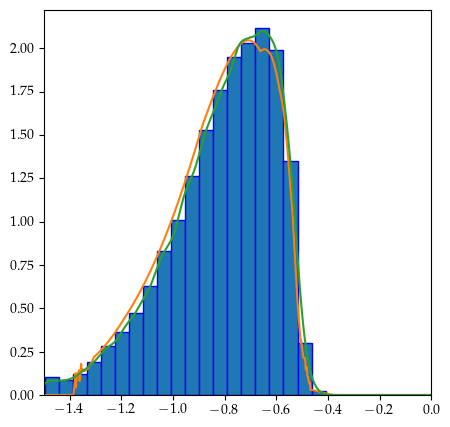

In [827]:
plt.figure(figsize=(5,5))
plt.hist(samples_w_0, density = True, bins=20, ec = 'b')
plt.plot(X_plot.reshape(-1), np.exp(flow.logpdf(transform.forward(X_plot)).reshape(-1) - transform.logdetchol))
plt.plot(X_plot, np.exp(log_dens))
plt.xlim(min(X_plot), max(X_plot))
plt.show()

In [760]:
kde.score_samples(-1.0*np.ones((1,1))) - prior['w_0'].logpdf(nested_point)

array([0.32081457])

In [761]:
np.trapz(np.exp(log_dens), X_plot.reshape(-1))

0.9990577022216209

In [762]:
np.trapz(np.exp(flow.logpdf(transform.forward(X_plot)).reshape(-1) - transform.logdetchol), X_plot.reshape(-1))

0.999637648928102

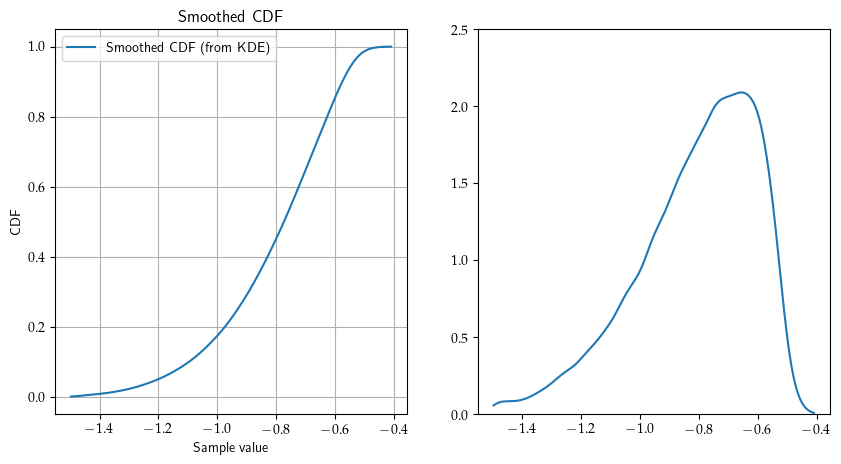

In [748]:
from scipy.stats import gaussian_kde
from scipy.integrate import cumulative_trapezoid

# Fit a KDE to the samples
kde = gaussian_kde(samples_w_0)

# Define a range of values for the CDF
x_vals = np.linspace(samples_w_0.min(), samples_w_0.max(), 1000)

# Compute the PDF (density)
pdf_vals = kde.evaluate(x_vals)

# Compute the CDF by integrating the PDF
cdf_vals = cumulative_trapezoid(pdf_vals, x_vals, initial=0)

# Normalize the CDF to ensure it goes from 0 to 1
cdf_vals /= cdf_vals[-1]

# Plot the smooth CDF
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x_vals, cdf_vals, label="Smoothed CDF (from KDE)")
plt.xlabel("Sample value")
plt.ylabel("CDF")
plt.title("Smoothed CDF")
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(x_vals, pdf_vals)
plt.ylim(0.0, 2.5)
plt.show()